<a href="https://colab.research.google.com/github/sunwoongc/data-science-transcription/blob/main/%5B210917%5DBike_Sharing_Demand_EDA_Ensemble_Model_(Top_10_Percentile).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sunnwoongchoi","key":"00037850b93dbb9f6c5993595ede0f49"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [3]:
!kaggle competitions download -c bike-sharing-demand

  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 43.0MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 54.1MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 106MB/s]


In [4]:
!ls

kaggle.json  sample_data  sampleSubmission.csv	test.csv  train.csv


# EDA & Ensemble Model (Top 10 Percentile)
[Source](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)

> Data generated by these systems are attractive to researchers because the travel period, departure location, arrival location, and elapsed time are explicitly recorded. Thus, the bicycle sharing system functions as a sensor network and can be used to study mobility in cities. Participants in the competition must combine past usage patterns with weather data to predict the demand for bicycle rental at the Capital Bike Share program in Washington, D.C.

Travel period(사용 기간), 출발 위치, 도착 위ㅏ치, 경과 시간이 명시적으로 기록되어 있기 때문에 매력적인 데이터라고 합니다. 도시의 모빌리티를 연구하는 데에 아주 좋은 데이터라고 합니다.

## About Dataset



### Overview

자전거 공유 시스템은 도시 전역의 키오스크 위치 네트워크를 통해 회원 가입, 대여 및 자전거 반납 절차가 자동화되는 자전거 대여 수단입니다.

### Data Fields

* datetime - 시간별날짜 + timestamp

* season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울

* holiday - 휴일 여부

* workingday - 주말이나 휴일이 아닌 날(일하는 날)

* weather 
    - 1: 맑음, 구름이 거의 없음, 약간 구름이 있음
    - 2: 안개+구름, 안개+Broken clouds, 안개+구름이 거의 없음, 안개
    - 3: 얕은 눈, 비 + 천둥 번개 + 흩어진 구름, 얕은 비 + 흩어진 구름
    - 4: 폭우 + 아이스 팔렛 + 천둥 번개 + 안개, 눈 + Fog(안개)

* temp - 섭씨 온도

* atmep - 체감 온도

* humidity - 상대 습도

* windspeed - 풍속

* casual - 미등록 회원의 대여량

* registered - 등록 회원의 대여량

* count - 총 대여량

In [5]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

### 데이터셋을 한번 읽어봅시다.

In [6]:
dailyData = pd.read_csv("train.csv")

## Data Summary

간단하게 3가지 단계를 통해 살펴보겠습니다.
* Dataset의 크기
* 간단한 몇 개 살펴보기
* 데이터를 구성하는 변수들의 Type

### Shape Of the Dataset

In [7]:
dailyData.shape

(10886, 12)

### Sample Of First Few Rows

In [8]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Variables Data Type

In [9]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Feature Engineering

계절, 공휴일, workingday, 날씨는 범주형 데이터가 되야하지만 현재는 int 자료형으로 되있습니다. 따라서 다음과 같이 데이터를 변환해 EDA를 시작해봅시다.

* "date", "hour", "weekDay", "month" 컬럼을 "datetime"으로 부터 만들어낸다.

* "season", "holiday", "workingday", "weather"의 자료형을 범주형으로 바꾼다.

* "datetime"을 컬럼을 버린다.

### Creating New Columns From "Datetime" Column

In [10]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

### Coercing To Category Type

In [11]:
categoryVariableList = ["hour", "weekday", "month", "season", "weather", "holiday", "workingday"]

for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

### Dropping Unnecessary Columns

In [12]:
dailyData = dailyData.drop(["datetime"], axis=1)

### Lets Start With Very Simple Visualization Of Variables DataType Count

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'variableType'),
 Text(0.5, 1.0, 'Variables DataType Count')]

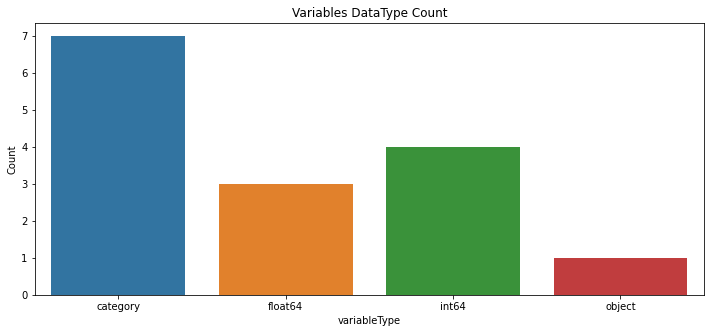

In [13]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType", 0:"count"})

# CategoricalDtype인 경우 어떤 category를 가지는가에 따라 다르게 정의되기때문에 각각 다른 카테고리로 분류된다.
# 따라서 str 꼴로 바꿔주고 groupby를 이용해 갯수를 세주는 방법을 선택했다.

dataTypeDf['variableType'] = dataTypeDf['variableType'].astype('str')
dataTypeDf = dataTypeDf.groupby(dataTypeDf['variableType']).sum()
dataTypeDf = dataTypeDf.reset_index().rename(columns={"index":"variableType", 0:"count"})

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

sns.barplot(data=dataTypeDf, x="variableType",  y="count", ax=ax)
ax.set(xlabel="variableType", ylabel="Count", title="Variables DataType Count")

## Missing Values Analysis

Missing value가 있는 지에 대해 "missingno" 라이브러리를 이용해 한번 확인해보겠습니다.

## Skewness In Distribution

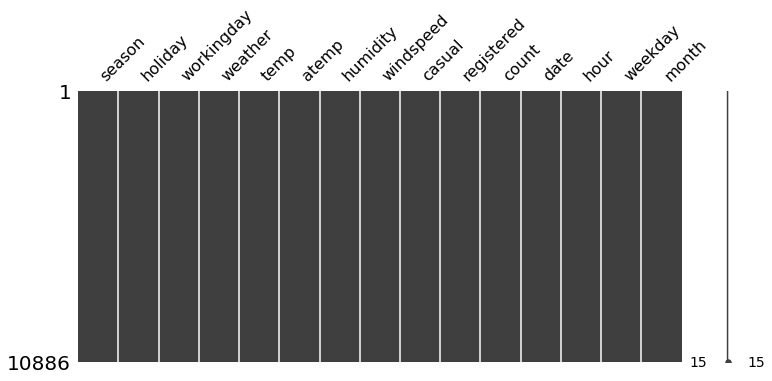

In [14]:
msno.matrix(dailyData, figsize=(12, 5))

## Outlier Analysis

Count 변수에 많은 이상치가 있기 때문에 데이터 자체가 오른쪽으로 치우쳐보일 수 있습니다. (Outer Quartile Limit을 벗어나는 값이 많다는 뜻입니다.) 

추가적으로 다음과 같은 추론을 boxplot을 그리면서 확인할 수 있습니다.

* Spring season has got relatively lower count. The dip in median value in boxplot gives evidence for it.
(봄에는 일반적으로 count값이 낮은데 이는 boxplot의 median값이 낮게 형성됐다는 것을 통해 확인할 수 있다.)

* The boxplot with "Hour Of The Day" is quiet interesting. The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.
("Hour Of The Day" 에 대한 boxplot값은 흥미로운 결과를 보여준다. median 값이 오전 7\~8시, 오후 5\~6시에 높게 나오는데, 이는 등하교, 출퇴근 사용자가 반영된 비율이다.)

* Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4
(대부분의 이상치가 "Working Day"에 더욱 몰려있다.)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count across Working Day')]

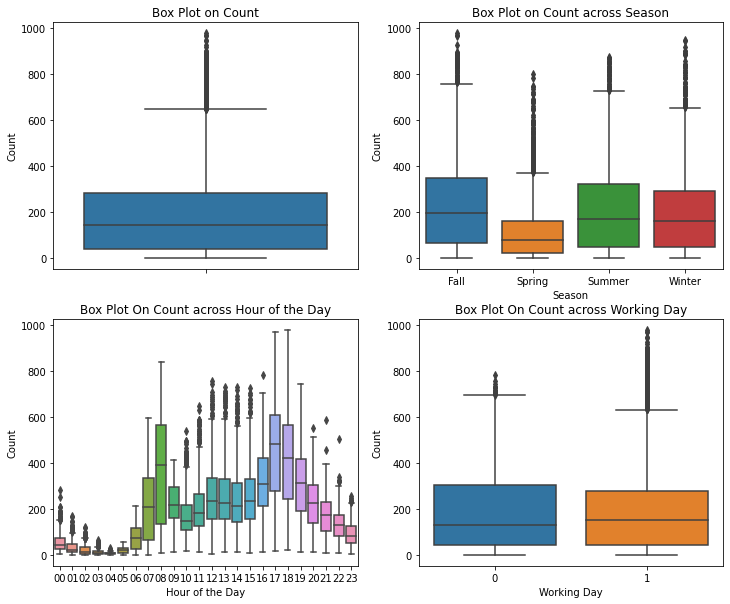

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
axs = axes.ravel()

sns.boxplot(data=dailyData, y="count", orient="v", ax=axs[0])
sns.boxplot(data=dailyData, y="count", x="season", orient="v", ax=axs[1])
sns.boxplot(data=dailyData, y="count", x="hour", orient="v", ax=axs[2])
sns.boxplot(data=dailyData, y="count", x="workingday", orient="v", ax=axs[3])

axs[0].set(ylabel="Count", title="Box Plot on Count")
axs[1].set(xlabel="Season", ylabel="Count", title="Box Plot on Count across Season")
axs[2].set(xlabel="Hour of the Day", ylabel="Count", title="Box Plot On Count across Hour of the Day")
axs[3].set(xlabel="Working Day", ylabel="Count", title="Box Plot On Count across Working Day")

### Lets Remove Outliers in the Count column

In [16]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean()) <= (3*dailyData["count"].std())]

Quantile을 이용해서 제외해도 유용할 것 같다.

In [17]:
print("Shape of the before outliers: ", dailyData.shape)
print("Shape of the after outliers: ", dailyDataWithoutOutliers.shape)

Shape of the before outliers:  (10886, 15)
Shape of the after outliers:  (10739, 15)


## Correlation Analysis

Dependent variable(종속 변수)에 대해서 이해를 하는 방법 중 흔히 사용되는 방법으로 correlation matrix가 있습니다.

"count"와 ["temp", "atemp", "humidity", "windspeed"]의 상관관계 그래프를 그려보겠습니다.

* temp and humidity features has got positive and negative correlation with count respectively. Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".
(온도와 습도는 각각 count 변수와 양의 상관관계, 음의 상관관계를 가집니다. 하지만 그 둘의 상관관계는 그렇게 두드러지지 않으며 count 변수도 "temp", "humidity"와는 약간의 상관관계만을 가집니다.)

* windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
(풍속은 그다지 유의미한 변수로 사용되지 않을 것입니다.)

* "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
("atemp"는 "temp"와 강한 상관관계가 있기 때문에, 유용하지 않습니다. 모델을 만들 때 이러한 변수들은 multicolinearity(다중공선성)을 보이기 때문에 한 변수는 삭제해줘야 합니다.)

* **"Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.
("Casual", "Registered" 변수도 영향을 끼치지 않습니다. 두 변수 모두 'leakage variables' 이기 때문에 모델을 만드는 과정에서 사용하지 않는 편이 좋습니다.)*

Seaborn의 Regression plot을 통해 두 변수의 관계를 효과적으로 살펴볼 수 있습니다. 여기서도 "count" vs "temp", "humidity", "windspeed"의 관계를 살펴보겠습니다.

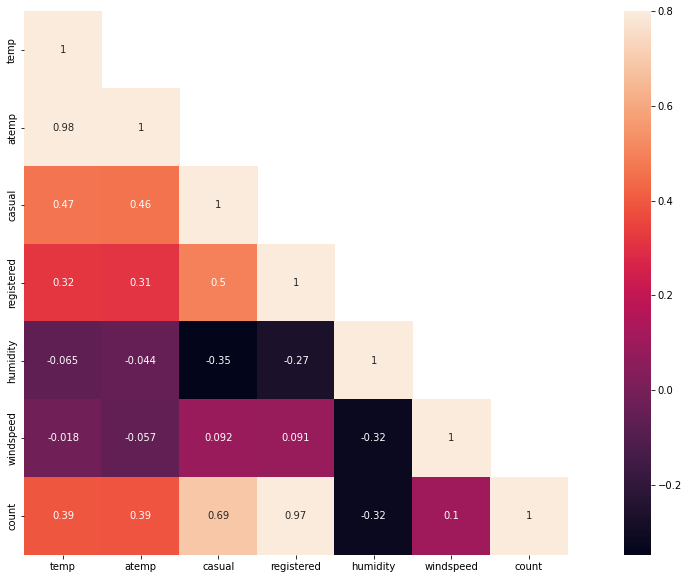

In [18]:
corrMatt = dailyData[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()
mask = np.array(corrMatt)

mask[np.tril_indices_from(mask)] = False # Return the indices for the lower-triangle of arr.

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

# mask = np.triu(corrMatt)
# sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

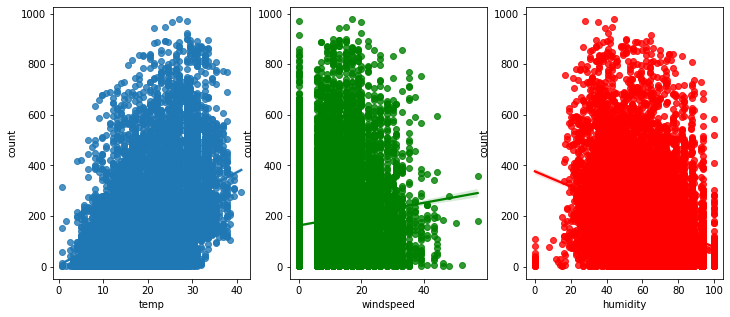

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)

sns.regplot(x="temp", y="count", data=dailyData, ax=ax1)
sns.regplot(x="windspeed", y="count", data=dailyData, ax=ax2, color='green')
sns.regplot(x="humidity", y="count", data=dailyData, ax=ax3, color='red')

## Visualizing Distribution of Data

"count" 변수 살펴보면 우측으로 치우쳐져있음을 확인할 수 있습니다. 대부분의 머신러닝 기술에서는 Normal distribution을 가지는 것이 좋습니다. 따라서 변환을 위해 log 변환을 취할 수 있습니다.

(이 방법에 대해 정리해봐야겠습니다. sqrt, box-cox, ...)

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

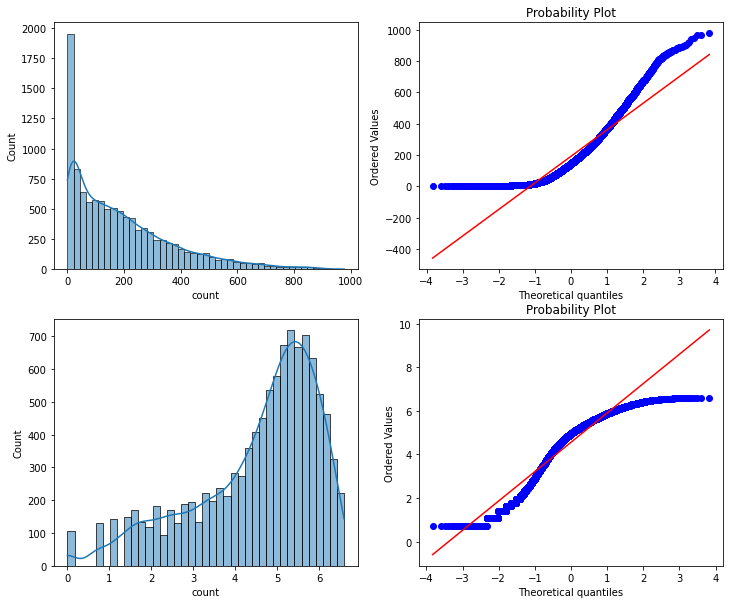

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(12, 10)
axs = axes.ravel()

sns.histplot(dailyData["count"], kde=True, ax=axs[0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axs[1])
sns.histplot(np.log(dailyDataWithoutOutliers["count"]), kde=True, ax=axs[2])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist="norm", fit=True, plot=axs[3])

distplot이 사라지기 때문에 histplot을 사용했습니다.

## Visualizing Count Vs (Month, Season, Hour, Weekday, Usertype)

* It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
(여름에 자전거를 타는 사람이 많은 것은 꽤 명백합니다. 따라서 6, 7, 8월에 수요가 많습니다.)

* On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
(평일에는 주로 오전 7\~8시, 오후 5\~6시에 자전거를 빌리는 경향이 있습니다.)

* Above pattern is not observed on "Saturday" and "Sunday". More people tend to rent bicycle between 10AM and 4PM.
(위의 패턴은 토, 일요일에는 나타지 않습니다. 토, 일요일에는 주로 오전 10시 \~ 오후 4시 사이에 자전거를 많이 빌립니다.)

* The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.
(오전 7\~8시, 오후 5\~6시 의 이용객은 대부분 등록 이용자들입니다.)

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour of the Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour of the Day user type'),
 None]

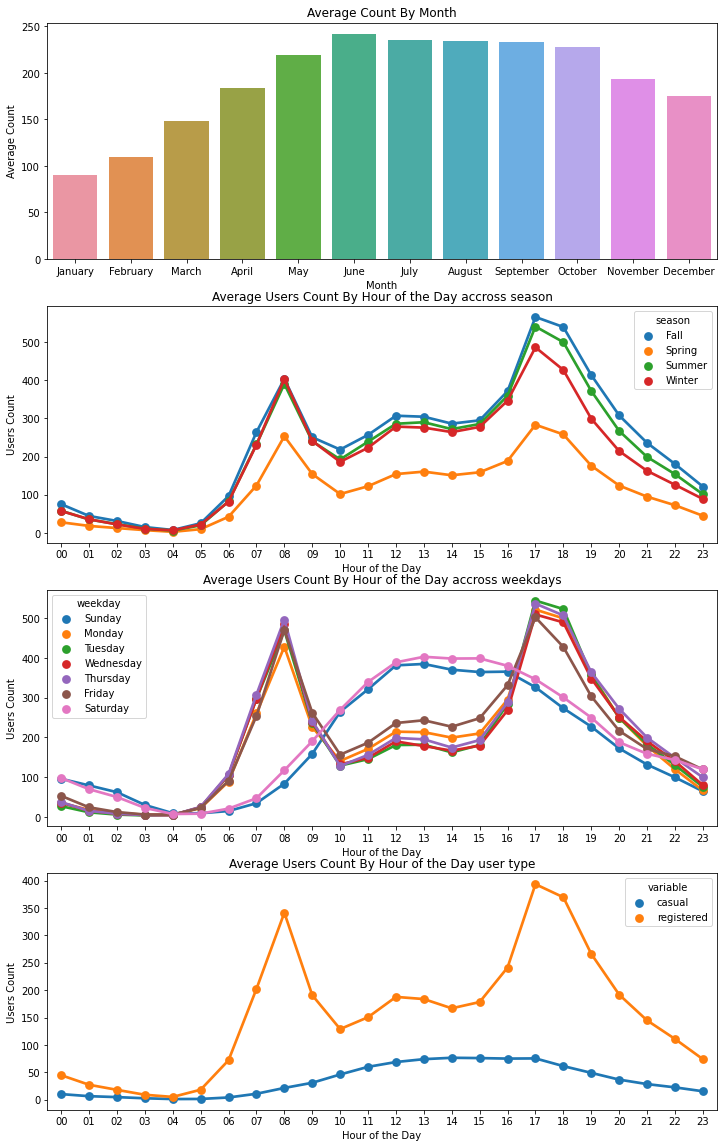

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig.set_size_inches(12, 20)

sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count", ascending=False)
sns.barplot(data=monthSorted, x="month", y="count", ax=ax1, order=sortOrder)
ax1.set(xlabel="Month", ylabel="Average Count", title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour", "season"], sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["season"],
              data=hourAggregated, join=True, ax=ax2)
ax2.set(xlabel="Hour of the Day", ylabel="Users Count", title="Average Users Count By Hour of the Day accross season", label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour", "weekday"], sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["weekday"],
              hue_order=hueOrder, data=hourAggregated, join=True, ax=ax3)
ax3.set(xlabel="Hour of the Day", ylabel="Users Count", title="Average Users Count By Hour of the Day accross weekdays", label='big')

hourTransformed = pd.melt(dailyData[["hour", "casual", "registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour", "variable"], sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"], hue=hourAggregated["variable"],
              data=hourAggregated, join=True, ax=ax4)
ax4.set(xlabel="Hour of the Day", ylabel="Users Count", title="Average Users Count By Hour of the Day user type", label='big')


***Line by Line***

## Filling 0's in windspeed using Random Forest

In [22]:
# Lets Read In Train And Test Data
dataTrain = pd.read_csv("train.csv")
dataTest = pd.read_csv("test.csv")

In [23]:
# Combine Train And Test
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

In [24]:
# Feature Engineering
data["date"] = data.datetime.apply(lambda x: x.split()[0])
data["hour"] = data.datetime.apply(lambda x: x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x: x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").month)

In [25]:
# Random Forest Model To Predict 0's In Windspeed
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]

rfModel_wind = RandomForestRegressor()
windColumns = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

In [26]:
# Coercing To Categorical Type
categoricalFeatureNames = ["season", "holiday", "workingday", "weather", "weekday", "month", "year", "hour"]
numericalFeatureNames = ["temp", "humidity", "windspeed", "atemp"]
dropFeatures = ["casual", "count", "datetime", "date", "registered"]

In [27]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [28]:
# Splitting Train And Test Data
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]

yLabels = dataTrain["count"]
yLabelsRegistered = dataTrain["registered"]
yLabelsCasual = dataTrain["casual"]

In [29]:
# Dropping Unncessary Variables
dataTrain = dataTrain.drop(dropFeatures, axis=1)
dataTest = dataTest.drop(dropFeatures, axis=1)

In [30]:
# RMSLE Scorer (Root Mean Square Logarithmic Error)
def rmsle(y, y_, convertExp=True):
    if convertExp:
        y = np.exp(y)
        y_ = np.exp(y_)

    log1 = np.nan_to_num(np.array([np.log(v+1) for v in y])) 
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc = (log1 - log2) ** 2

    return np.sqrt(np.mean(calc))

Replace NaN with zero and infinity with large finite numbers (default behaviour) or with the numbers defined by the user using the nan, posinf and/or neginf keywords.

## Linear Regression Model

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

lModel = LinearRegression()

yLabelsLog = np.log1p(yLabels)
lModel.fit(X=dataTrain, y=yLabelsLog)

preds = lModel.predict(X=dataTrain)
print("RMSLE Value for Linear Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value for Linear Regression:  0.9779653037978768


## Regularization Model - Ridge

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value for Ridge Regression:  0.9779652887264589


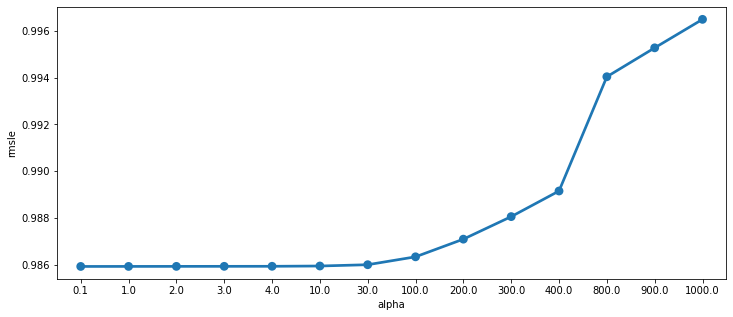

In [39]:
ridge_m_ = Ridge()
ridge_params_ = {'max_iter': [3000], 'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                            ridge_params_,
                            scoring=rmsle_scorer,
                            cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit(dataTrain, yLabelsLog)
preds = grid_ridge_m.predict(X=dataTrain)
print(grid_ridge_m.best_params_)
print("RMSLE Value for Ridge Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_ridge_m.cv_results_) 
df["alpha"] = df["params"].apply(lambda x: x["alpha"]) 
df["rmsle"] = df["mean_test_score"].apply(lambda x: -x) 
sns.pointplot(data=df, x="alpha", y="rmsle", ax=ax)

`cv_results` 관련해서는 다음의 [공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)를 참고해서 수정했습니다.

## Regularization Model - Lasso

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value for Lasso Regression:  0.9779652887264589


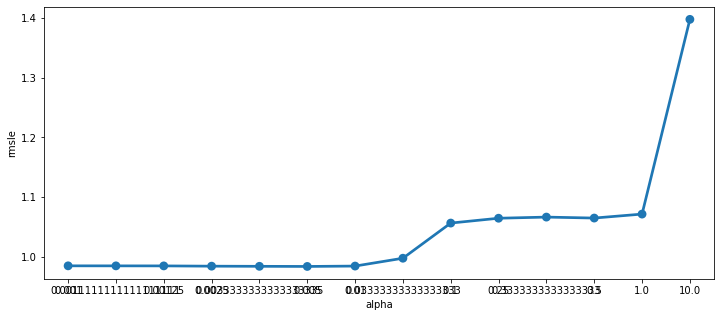

In [41]:
lasso_m_ = Lasso()
alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = {'max_iter': [3000], 'alpha': alpha}

grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(dataTrain, yLabelsLog)
pred = grid_lasso_m.predict(X=dataTrain)
print(grid_lasso_m.best_params_)
print("RMSLE Value for Lasso Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_lasso_m.cv_results_) 
df["alpha"] = df["params"].apply(lambda x: x["alpha"]) 
df["rmsle"] = df["mean_test_score"].apply(lambda x: -x) 
sns.pointplot(data=df, x="alpha", y="rmsle", ax=ax)

## Ensemble Models - Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain, yLabelsLog)
preds = rfModel.predict(X=dataTrain)
print("RMSLE Value for Random Forest: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value for Random Forest:  0.1036674572317268


## Ensemble Models - GradientBoost

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain, yLabelsLog)
pred = gbm.predict(X=dataTrain)
print("RMSLE Value for GradientBoost: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value for GradientBoost:  0.1036674572317268


Train과 Test의 분포를 확인해봅시다. 분포가 비교적 비슷하게 나오며, 이는 예측이 나쁘지 않은 수준이며 overfitting 문제가 있지 않음을 알 수 있습니다.

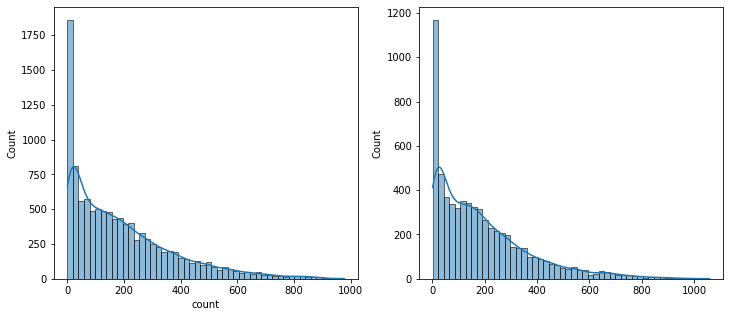

In [46]:
predsTest = gbm.predict(X=dataTest)
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.histplot(yLabels, ax=ax1, bins=50, kde=True)
sns.histplot(np.exp(predsTest), ax=ax2, bins=50, kde=True)